In [1]:
import numpy as np

import sys
sys.path.insert(0, '../01_code')

from simple_Hamiltonian_systems import HarmonicOscillator
from main_simple_Hamiltonian_systems import plot_Ham_sys

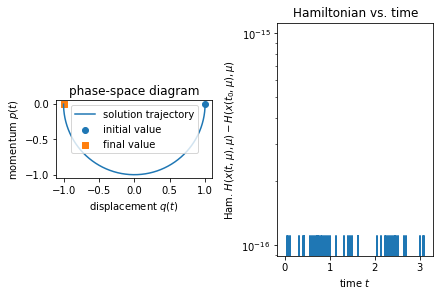

In [2]:
## Harmonic oscillator
model = HarmonicOscillator()
mu = {'m': 1., 'k': 1., 'f': 0., 'q0': 1., 'p0': 0.}
# compute solution for all t in [0, pi]
X, t = model.solve(0, np.pi, np.pi/1e3, mu)
all_Ham = model.Ham(X, mu)
# plot solution
plot_Ham_sys(X, t, all_Ham)